In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
#from generator import DataGenerator
import keras
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report
import seaborn as sns

In [ ]:
traindir = 'E:/Fall 23/CSE438/Final Paper/Final Dataset/train/'
testdir = 'E:/Fall 23/CSE438/Final Paper/Final Dataset/test/'

In [ ]:
# Data augmentation
labels = os.listdir(traindir)
train_datagen = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=15,
                              zoom_range=0.15,
                                   validation_split=0.2)

In [ ]:
IMG_SIZE = 224
batch_size = 16

train_generator = train_datagen.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=16,
    subset='training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    traindir,
    target_size=(IMG_SIZE , IMG_SIZE),
    batch_size=16,
    subset='validation',
    class_mode='categorical')

valid_X, valid_Y = next(validation_generator)

Found 11200 images belonging to 10 classes.
Found 2790 images belonging to 10 classes.


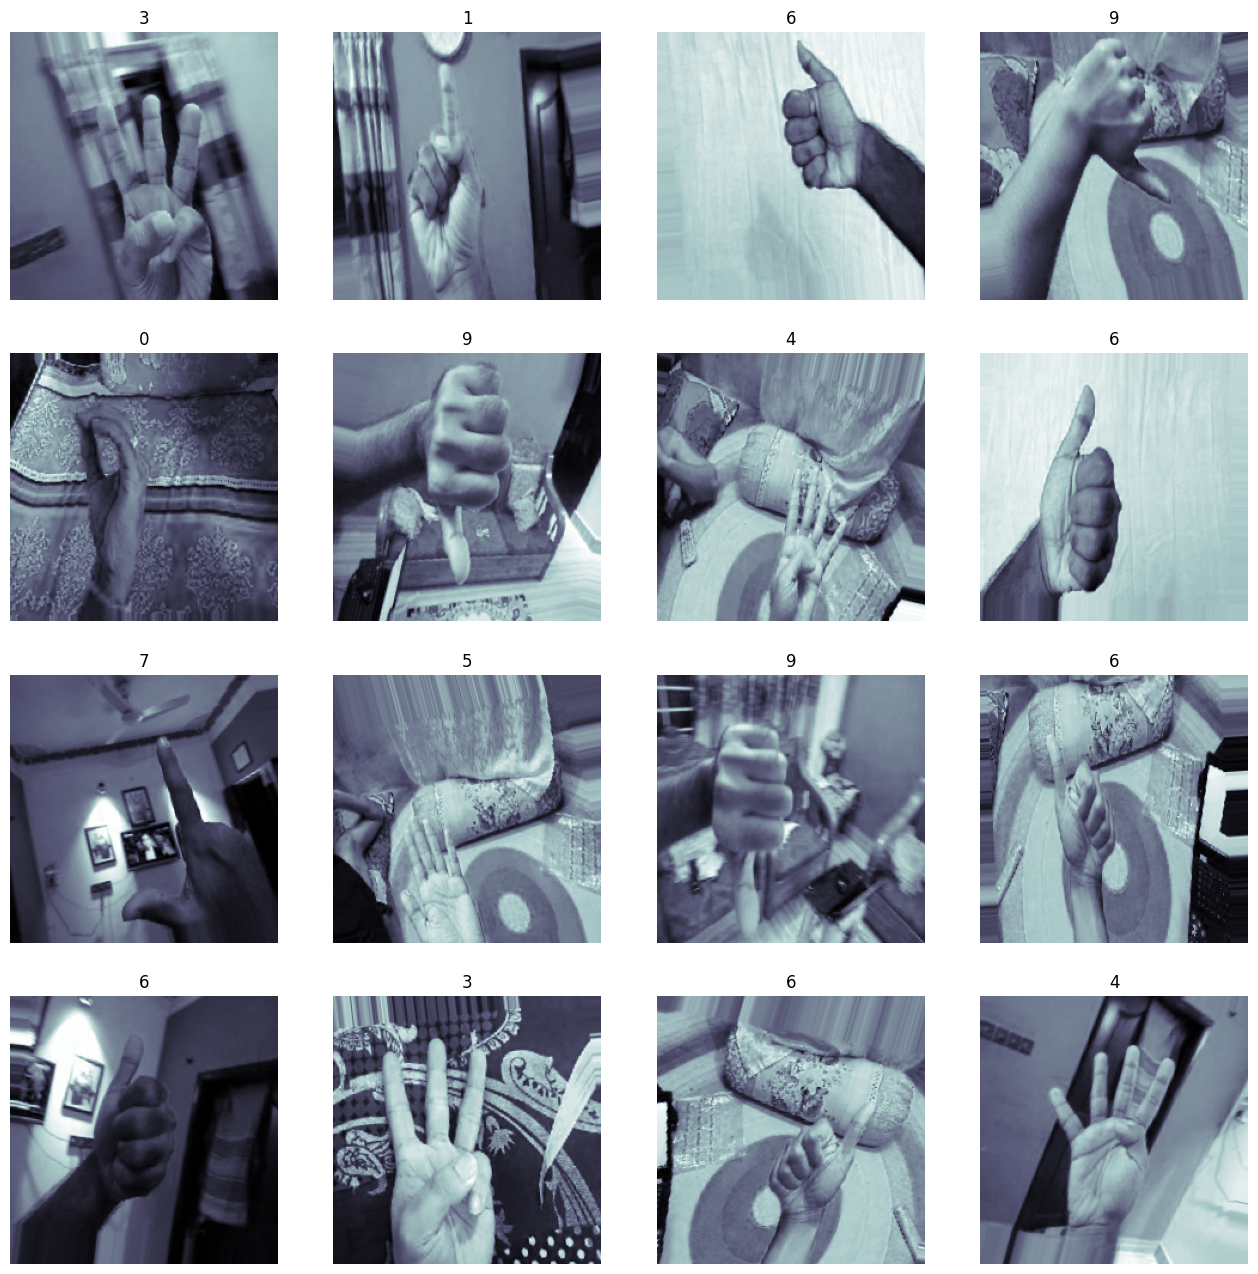

In [ ]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

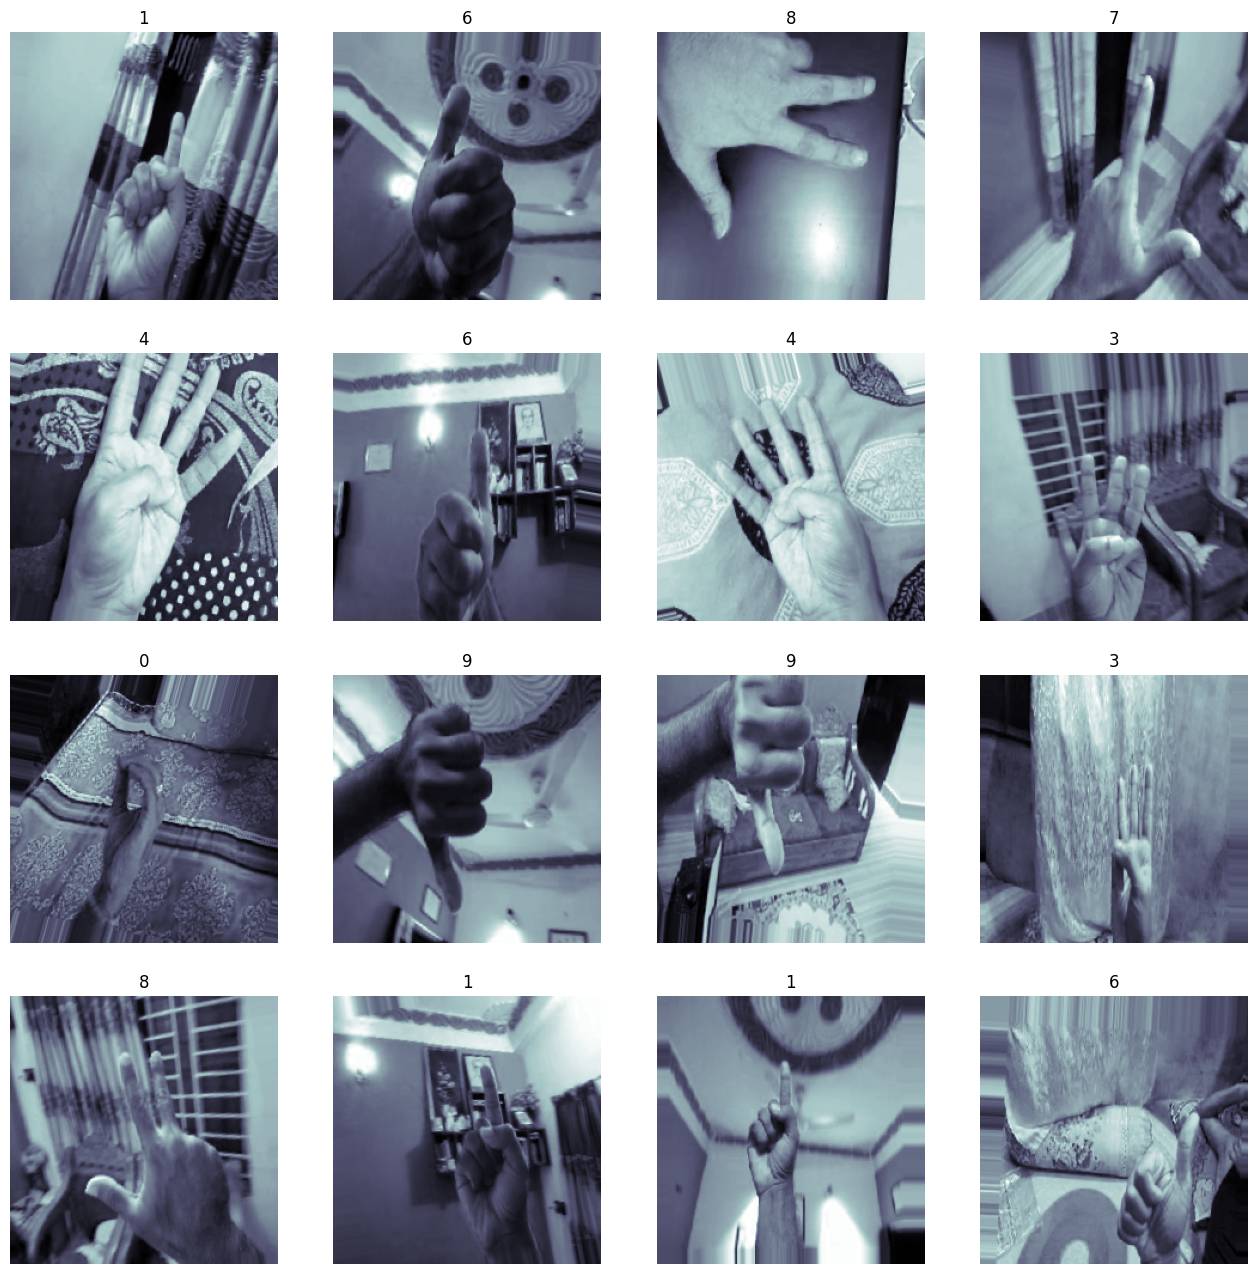

In [ ]:
t_x, t_y = next(train_generator)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(labels, c_y)
                             if n_score>0.5]))
    c_ax.axis('off')

In [ ]:
#defining VGG16 model
def vgg16_model():
    img_in = Input(t_x.shape[1:])         #input of model
    model = VGG16(include_top= False , # remove  the 3 fully-connected layers at the top of the network
                weights='imagenet',      # pre train weight
                input_tensor= img_in,
                input_shape= t_x.shape[1:],
                pooling ='avg')
    x = model.output
    predictions = Dense(4, activation="softmax", name="predictions")(x)    # fuly connected layer for predict class
    model = Model(inputs=img_in, outputs=predictions)
    return model

In [ ]:
model = vgg16_model()
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['accuracy'])
model.summary()


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
filepath="vgg16.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 3,verbose = 1,restore_best_weights = True)
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(train_generator,
                                  steps_per_epoch=500,
                                  validation_data = (valid_X,valid_Y),
                                  epochs = 75,
                                  callbacks=callbacks_list)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(test_X)

pred_class = []
for i in range(len(y_pred)):
    pred_class.append(np.argmax(y_pred[i]))

actual_class = []
for i in range(len(test_Y)):
    actual_class.append(np.argmax(test_Y[i]))

print(' Test accuracy = ',accuracy_score(pred_class,actual_class))

print ('Train Accuracy', np.mean(history.history['accuracy']))
print ('Train Loss', np.mean(history.history['loss']))
print ('Validation Accuracy', np.mean(history.history['val_accuracy']))
print ('Validation Loss', np.mean(history.history['val_loss']))

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    labels = ['CNV','DME','DRUSEN','NORMAL']
    sns.set(font_scale=1.2)
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="BuPu", fmt=".1f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    return C

cm = plot_confusion_matrix(actual_class,pred_class)

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Recall/TPR = {}".format(TPR))

# Specificity or true negative rate
TNR = TN/(TN+FP)
print("Specificity/TNR = {}".format(TNR))

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision/PPV = {}".format(PPV))

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative Predict Value = {}".format(NPV))

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("False Positive Rate = {}".format(FPR))

# False negative rate
FNR = FN/(TP+FN)
print("False Negative Rate = {}".format(FNR))

# False discovery rate
FDR = FP/(TP+FP)
print("False discovery rate = {}".format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall Accuracy = {}".format(ACC))
